# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [8]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['sales_channel'])

In [9]:
df["trip_type"].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [10]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['trip_type'])

In [11]:
df["booking_origin"].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [12]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['booking_origin'])

In [13]:
df["route"].unique()

array(['AKLDEL', 'AKLHGH', 'AKLHND', 'AKLICN', 'AKLKIX', 'AKLKTM',
       'AKLKUL', 'AKLMRU', 'AKLPEK', 'AKLPVG', 'AKLTPE', 'AORICN',
       'AORKIX', 'AORKTM', 'AORMEL', 'BBIMEL', 'BBIOOL', 'BBIPER',
       'BBISYD', 'BDOCTS', 'BDOCTU', 'BDOHGH', 'BDOICN', 'BDOIKA',
       'BDOKIX', 'BDOMEL', 'BDOOOL', 'BDOPEK', 'BDOPER', 'BDOPUS',
       'BDOPVG', 'BDOSYD', 'BDOTPE', 'BDOXIY', 'BKICKG', 'BKICTS',
       'BKICTU', 'BKIHND', 'BKIICN', 'BKIKIX', 'BKIKTM', 'BKIMEL',
       'BKIMRU', 'BKIOOL', 'BKIPEK', 'BKIPER', 'BKIPUS', 'BKIPVG',
       'BKISYD', 'BKIXIY', 'BLRICN', 'BLRMEL', 'BLRPER', 'BLRSYD',
       'BOMMEL', 'BOMOOL', 'BOMPER', 'BOMSYD', 'BTJJED', 'BTUICN',
       'BTUPER', 'BTUSYD', 'BTUWUH', 'BWNCKG', 'BWNDEL', 'BWNHGH',
       'BWNIKA', 'BWNKTM', 'BWNMEL', 'BWNOOL', 'BWNPER', 'BWNSYD',
       'BWNTPE', 'CANDEL', 'CANIKA', 'CANMEL', 'CANMRU', 'CANOOL',
       'CANPER', 'CANSYD', 'CCUMEL', 'CCUMRU', 'CCUOOL', 'CCUPER',
       'CCUSYD', 'CCUTPE', 'CEBMEL', 'CEBOOL', 'CEBPER', 'CEBS

In [14]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['route'])

In [15]:
print(df.head())

   num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
0               2            262              19            7           6   
1               1            112              20            3           6   
2               2            243              22           17           3   
3               1             96              31            4           6   
4               2             68              22           15           3   

   wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
0                    1                     0                      0   
1                    0                     0                      0   
2                    1                     1                      0   
3                    0                     0                      1   
4                    1                     0                      1   

   flight_duration  booking_complete  ...  route_TGGXIY  route_TPETRZ  \
0             5.52                 0 

In [16]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,route_TGGXIY,route_TPETRZ,route_TPETWU,route_TPEURT,route_TPEVTE,route_TRZWUH,route_TRZXIY,route_TWUWUH,route_TWUXIY,route_URTXIY
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560,...,0.000040,0.000500,0.000120,0.000020,0.000040,0.000260,0.000120,0.000040,0.000140,0.000020
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643,...,0.006324,0.022355,0.010954,0.004472,0.006324,0.016123,0.010954,0.006324,0.011831,0.004472
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

In [17]:
# Separate features and target
y = df['booking_complete']                  # Target
X = df.drop('booking_complete', axis=1)     # Features

In [18]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Evaluate the model
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

In [21]:
# Perform cross-validation
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

In [22]:
# Show average scores
for metric, scores in cv_results.items():
    if 'test' in metric:
        print(f"{metric}: {np.mean(scores):.3f}")

test_accuracy: 0.851
test_precision: 0.505
test_recall: 0.137
test_f1: 0.216
test_roc_auc: 0.785


In [23]:
# Extract feature importances
importances = model.feature_importances_
feature_names = X.columns

In [24]:
# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

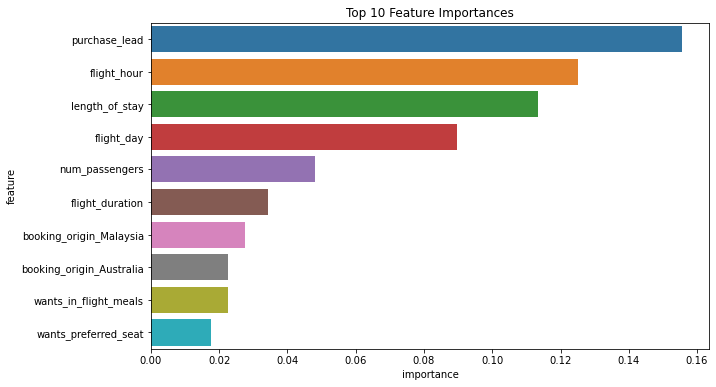

In [25]:
# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df.head(10))  # top 20 features
plt.title('Top 10 Feature Importances')
plt.show()